We have an interest in knowing exactly what stars PSFEx uses to do its analysis and which it chooses to skip. Fortunately, PSFEx gives us that information in its output catalog. Unfortunately, it's ordered in such a way to make it next to impossible to parse it any meangingful way. PSFEx writes out the index of used stars by CCD, so you get a long file of numbers 1-~500 instead of 1-~20,000. This wouldn't itself be a problem, if each CCD was in sorted order. However, for god knows what reason, when PSFEx skips a star *it takes a star from the end of the CCD and puts it in that place.* This makes it so **so** hard to parse them simply to just get a CCD and an index of the used stars. I'm going to try to come up with something clever in this notebook. 

In [8]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
from collections import defaultdict
from glob import glob

expid = 149440
data_dir = '/u/ki/swmclau2/des/DeconvOutput/00%d/'%expid

bad_star_idxs = np.load(data_dir+'%d_bad_star_idxs.npy'%expid)
print bad_star_idxs

[    1     6     7 ..., 28805 28806 28815]


In [22]:
fits_files = sorted(glob(data_dir+'*_seldeconv.fits'))

meta_hdulist = [fits.open(f) for f in fits_files]
hdu_lengths = np.zeros((62,))

for ccd_num, hdulist in enumerate(meta_hdulist):
    hdu_lengths[ccd_num] = hdulist[2].data.shape[0]

out_cat = fits.open(data_dir+'%d_outcat.cat'%expid)
used_stars = out_cat[2].data['SOURCE_NUMBER']

ccd_dict = defaultdict(list)
for idx, bs in enumerate(bad_star_idxs):
    for ccd, hdul in enumerate(hdu_lengths):
        if bs > hdul:
            bs-=hdul
        else:
            ccd_dict[ccd+1].append(int(bs+1) )
            break
            
for key, val in ccd_dict.iteritems():
    print key,val

1 [2, 7, 8, 9, 11, 16, 17, 24, 26, 30, 65, 68, 71, 75, 76, 77, 80, 83, 85, 87, 89, 92, 93, 94, 97, 100, 101, 102, 106, 107, 114, 118, 120, 121, 123, 125, 130, 131, 134, 136, 139, 140, 146, 150, 153, 155, 156, 157, 160, 163, 165, 167, 168, 169, 171, 174, 177, 179, 181, 188, 189, 190, 191, 194, 202, 203, 208, 210, 214, 216, 218, 226, 232, 239, 246, 253, 265, 272, 273, 275, 281, 285, 292, 299, 301, 304, 305, 306, 327, 329, 331, 332, 336, 337, 342, 346, 347, 351, 357, 365, 366, 369, 370, 372, 373, 385, 387, 390, 398, 399, 403, 409, 412, 419, 427, 432]
2 [2, 5, 8, 9, 11, 12, 19, 23, 26, 31, 33, 37, 54, 55, 56, 57, 59, 64, 67, 68, 71, 75, 80, 81, 86, 88, 90, 102, 107, 110, 113, 115, 119, 121, 122, 124, 125, 127, 137, 138, 139, 140, 141, 143, 144, 154, 155, 158, 161, 162, 165, 167, 169, 174, 176, 179, 182, 184, 185, 186, 187, 188, 191, 194, 196, 199, 200, 202, 205, 207, 209, 212, 220, 221, 222, 223, 224, 231, 233, 234, 235, 238, 239, 241, 242, 243, 245, 248, 250, 251, 254, 255, 259, 261, 268,

In [10]:
ccd_jumps = np.cumsum(hdu_lengths)

In [11]:
displacement = 0
hdl_set = set(hdu_lengths)
psfex_bad_stars = {}
for idx, val in enumerate(used_stars):
    #print '\n', idx,
    if idx == 0 or idx == len(used_stars)-1:
        continue
    #print '0',
    delta_1 = val - used_stars[idx-1]
    #print '1',
    delta_2 = used_stars[idx+1] - used_stars[idx-1]
    #print '2',
    if delta_1 == 1 or (used_stars[idx-1] in hdl_set and val == 1):
        continue
    elif delta_1 == 2:
        #print '3'
        bsi = idx + displacement
        ccd_jump_idx = 0
        for cji, ccdj in enumerate(ccd_jumps):
            if ccdj > bsi:
                ccd_jump_idx = cji-1
                break
            else:
                ccd_jump_idx = len(ccd_jumps)-1
        bsi-= ccd_jumps[ccd_jump_idx]
        ccd = ccd_jump_idx + 1 #off by one, 0 based indexing
        psfex_bad_stars[ccd] = bsi
            
        displacement += 1
    else:
        #print '4'
        if delta_2 == 2: #fucking swap thing
            bsi = idx + displacement
            ccd_jump_idx = 0
            for cji, ccdj in enumerate(ccd_jumps):
                if ccdj > bsi:
                    ccd_jump_idx = cji-1
                    break
                else:
                    ccd_jump_idx = len(ccd_jumps)-1
            bsi-= ccd_jumps[ccd_jump_idx]
            ccd = ccd_jump_idx + 1 #off by one, 0 based indexing
            psfex_bad_stars[ccd] = bsi
            
            hdl_set.add(val-1)#this idx was swapped somewhere
            
        else: #multiple in a row
            for i in xrange(delta_1-1):
                
                bsi = idx + displacement
                ccd_jump_idx = 0
                for cji, ccdj in enumerate(ccd_jumps):
                    if ccdj > bsi:
                        ccd_jump_idx = cji-1
                        break
                else:
                    ccd_jump_idx = len(ccd_jumps)-1
                bsi-= ccd_jumps[ccd_jump_idx]
                ccd = ccd_jump_idx + 1 #off by one, 0 based indexing
                psfex_bad_stars[ccd] = bsi

                displacement += 1    

for key, val in psfex_bad_stars.iteritems():
    print key, val

1 433.0
2 140.0
3 363.0
4 469.0
5 294.0
6 325.0
7 455.0
8 441.0
10 299.0
11 221.0
12 295.0
13 455.0
15 412.0
16 411.0
17 462.0
18 403.0
19 399.0
20 90.0
21 370.0
22 205.0
23 427.0
24 416.0
25 387.0
26 447.0
27 420.0
28 505.0
29 453.0
30 221.0
31 342.0
32 338.0
33 315.0
34 474.0
35 499.0
36 466.0
37 429.0
38 383.0
39 430.0
40 481.0
41 277.0
42 504.0
43 254.0
44 429.0
45 467.0
46 425.0
48 443.0
49 507.0
50 222.0
51 489.0
52 365.0
53 509.0
54 478.0
55 477.0
56 457.0
58 305.0
59 279.0
60 417.0


In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

import DeconvolvePSF.colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.set_cmap(cmaps.viridis)

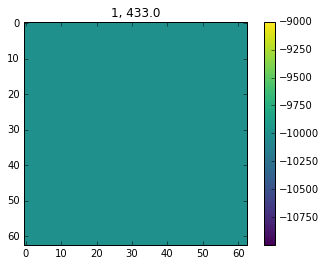

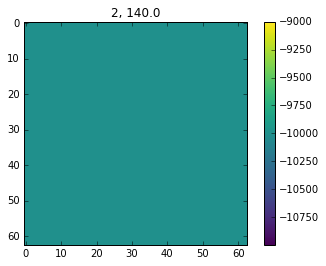

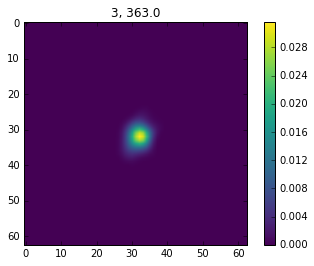

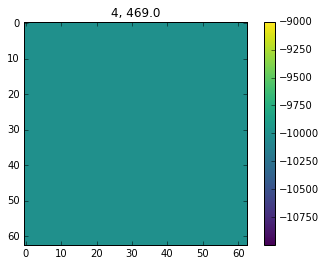

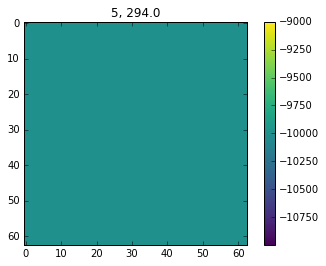

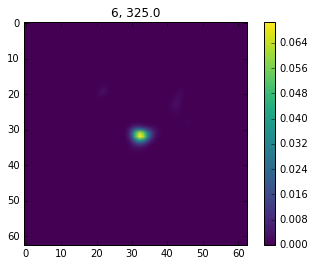

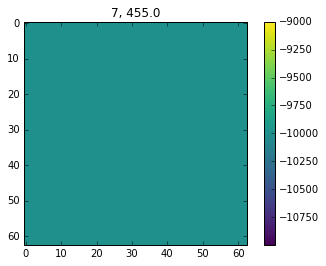

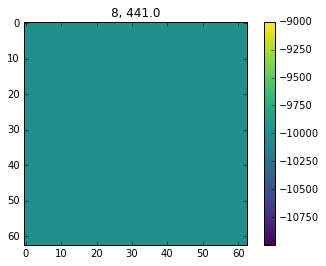

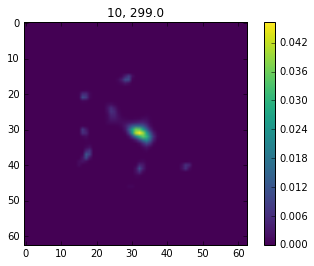

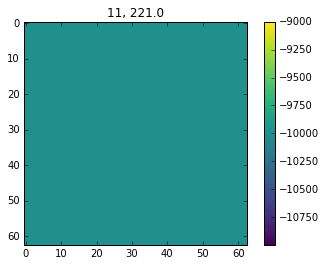

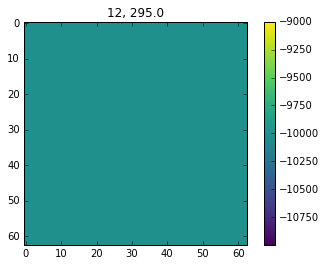

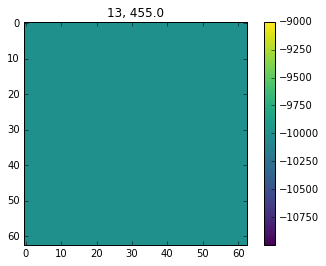

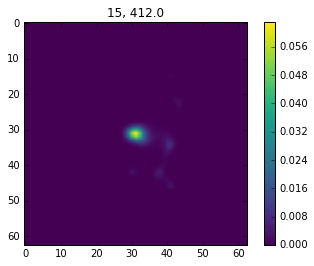

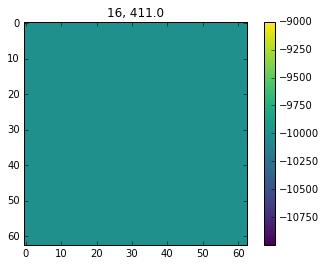

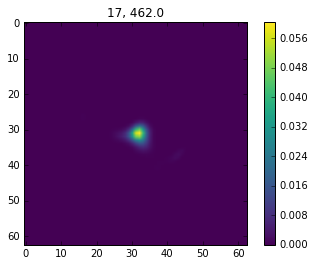

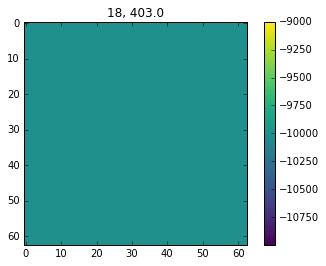

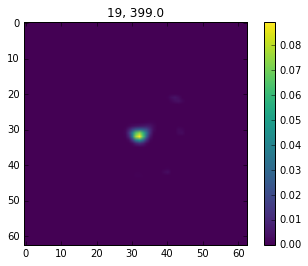

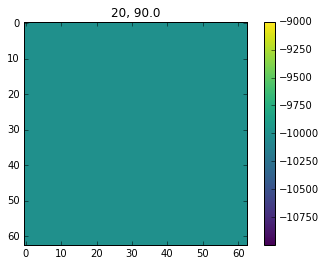

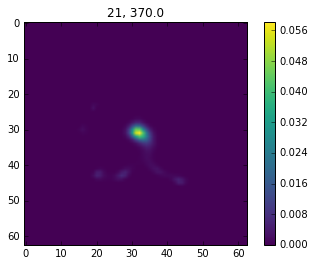

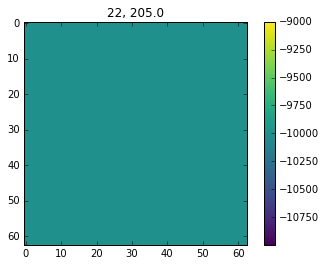

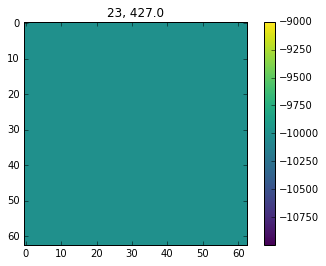

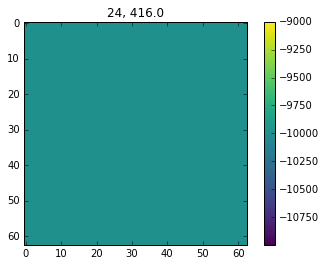

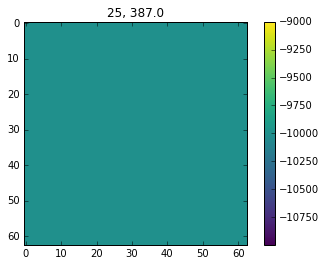

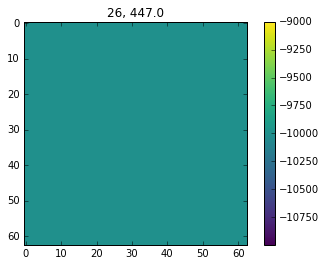

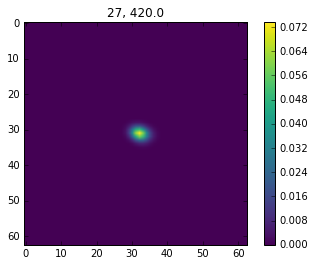

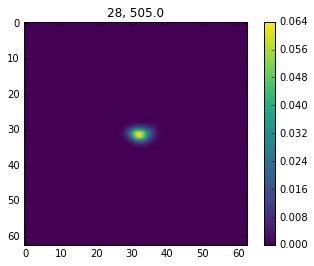

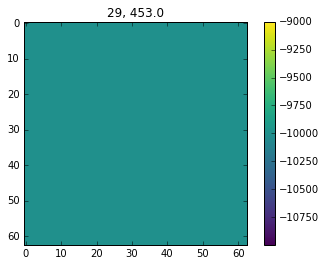

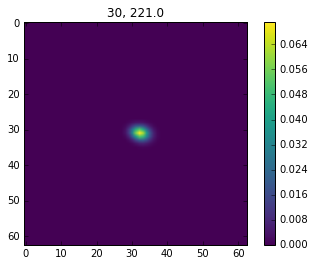

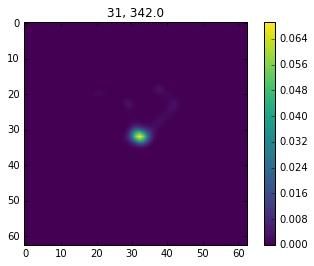

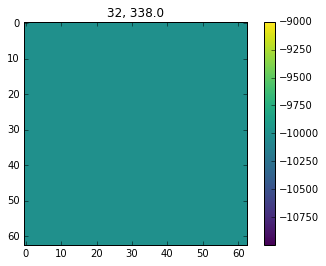

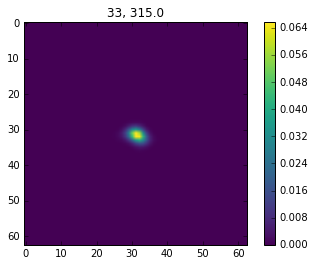

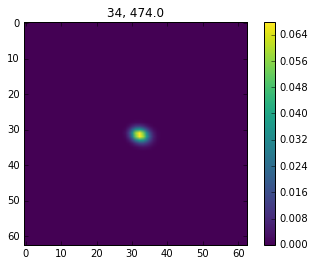

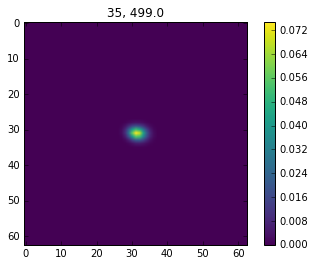

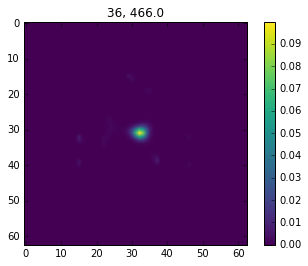

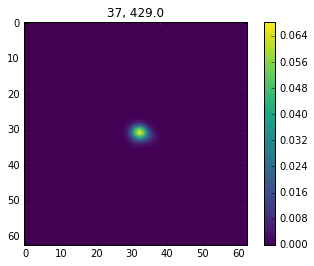

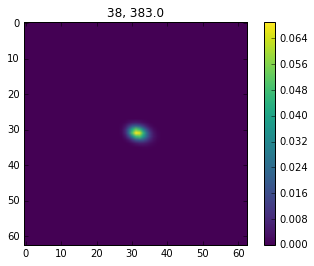

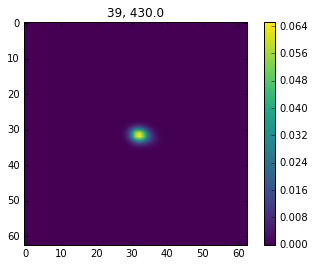

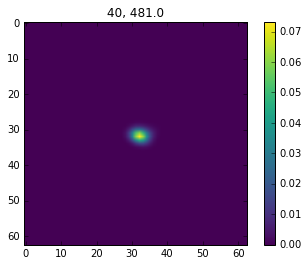

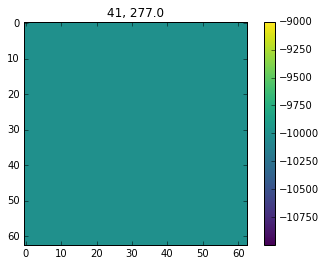

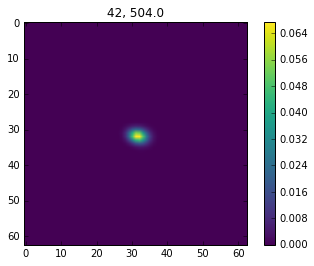

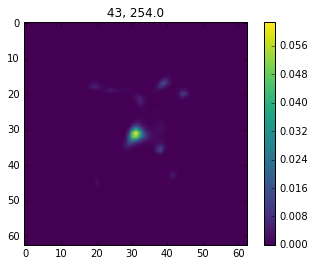

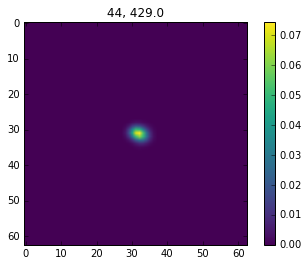

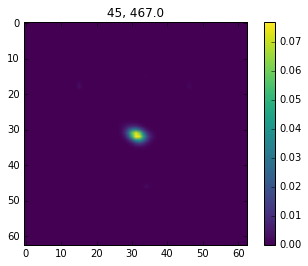

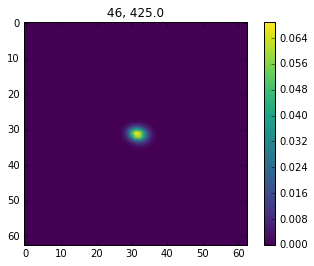

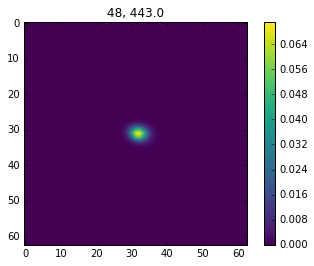

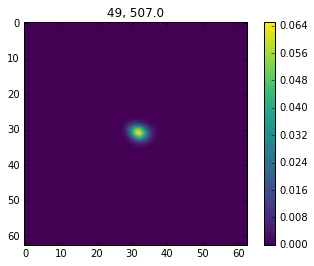

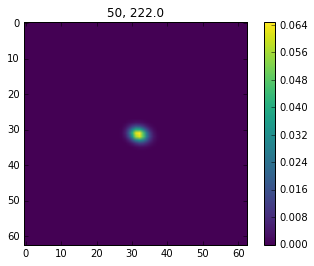

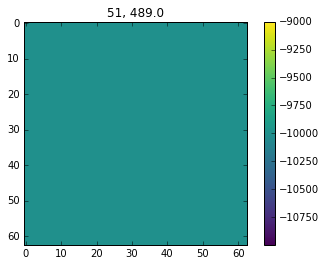

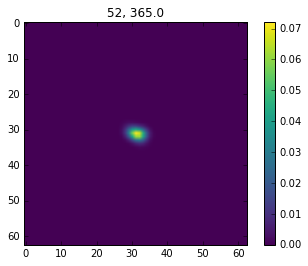

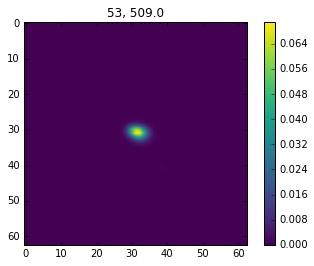

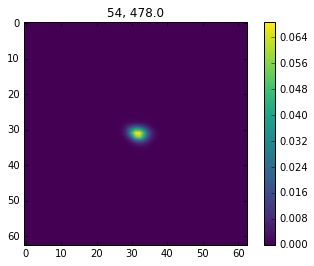

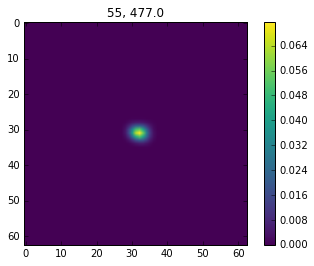

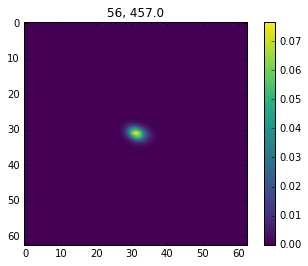

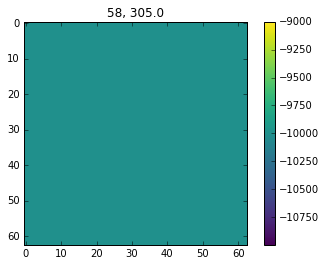

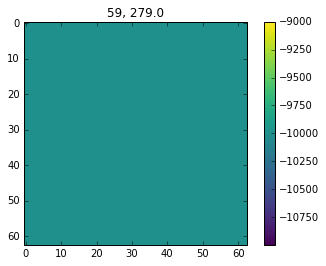

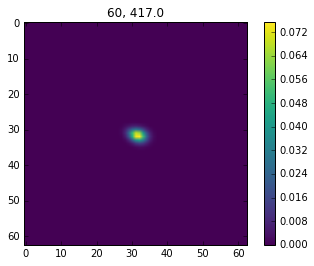

In [13]:
for key, val in psfex_bad_stars.iteritems():
    hdu = meta_hdulist[key]
    vig = hdu[2].data['VIGNET'][int(val)]
    plt.title('%s, %s'%(key, val))
    im = plt.imshow(vig)
    plt.colorbar(im)
    plt.show()

In [17]:
print len(psfex_bad_stars)

56


In [21]:
print starminusopt.shape[0] -len(used_stars)

463


In [18]:
out_base = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/'
deconvstarsminusopt_loc = out_base + '{0:08d}/{0}_stars_minus_opt.npy'.format(expid)
starminusopt = np.load(deconvstarsminusopt_loc)

MASK_VAL = -9999
good_stars = []
for idx, resid in enumerate(starminusopt):
    if not np.any(resid == MASK_VAL):
        good_stars.append(idx)
good_stars = np.array(good_stars)
print(starminusopt.shape[0]-good_stars.shape[0])

8555


In [19]:
print (starminusopt.shape[0]-good_stars.shape[0])/float(starminusopt.shape[0])

0.296801276714
